Ye ab tak ka code:

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


def process_image(frame):
    
    def cal_undistort(img):
        # Reads mtx and dist matrices, peforms image distortion correction and returns the undistorted image

        import pickle

        # Read in the saved matrices
        my_dist_pickle = pickle.load( open( "output_files/calib_pickle_files/dist_pickle.p", "rb" ) )
        mtx = my_dist_pickle["mtx"]
        dist = my_dist_pickle["dist"]

        undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
        #undistorted_img =  cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)   #Use if you use cv2 to import image. ax.imshow() needs RGB image
        return undistorted_img

    
    def yellow_threshold(img, sxbinary):
        # Convert to HLS color space and separate the S channel
        # Note: img is the undistorted image
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        h_channel = hls[:,:,0]
        # Threshold color channel
        s_thresh_min = 100
        s_thresh_max = 255
        
        #for 360 degree, my value for yellow ranged between 35 and 50. So uska half kar diya
        h_thresh_min = 10    
        h_thresh_max = 25

        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

        h_binary = np.zeros_like(h_channel)
        h_binary[(h_channel >= h_thresh_min) & (h_channel <= h_thresh_max)] = 1

        # Combine the two binary thresholds
        yellow_binary = np.zeros_like(s_binary)
        yellow_binary[(((s_binary == 1) | (sxbinary == 1) ) & (h_binary ==1))] = 1
        return yellow_binary
    
    def xgrad_binary(img, thresh_min=30, thresh_max=100):
        # Grayscale image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Sobel x
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        # Threshold x gradient
        #thresh_min = 30    #Already given above
        #thresh_max = 100

        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        return sxbinary
    
    def white_threshold(img, sxbinary, lower_white_thresh = 170):
        r_channel = img[:,:,0]
        g_channel = img[:,:,1]
        b_channel = img[:,:,2]
        # Threshold color channel
        r_thresh_min = lower_white_thresh
        r_thresh_max = 255
        r_binary = np.zeros_like(r_channel)
        r_binary[(r_channel >= r_thresh_min) & (r_channel <= r_thresh_max)] = 1
        
        g_thresh_min = lower_white_thresh
        g_thresh_max = 255
        g_binary = np.zeros_like(g_channel)
        g_binary[(g_channel >= g_thresh_min) & (g_channel <= g_thresh_max)] = 1

        b_thresh_min = lower_white_thresh
        b_thresh_max = 255
        b_binary = np.zeros_like(b_channel)
        b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1

        white_binary = np.zeros_like(r_channel)
        white_binary[((r_binary ==1) & (g_binary ==1) & (b_binary ==1) & (sxbinary==1))] = 1
        return white_binary
        
    def thresh_img(img):
                       
       
        #sxbinary = xgrad_binary(img, thresh_min=30, thresh_max=100)
        sxbinary = xgrad_binary(img, thresh_min=25, thresh_max=130)
        yellow_binary = yellow_threshold(img, sxbinary)     #(((s) | (sx)) & (h))
        white_binary = white_threshold(img, sxbinary, lower_white_thresh = 150)
        
        # Combine the two binary thresholds
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[((yellow_binary == 1) | (white_binary == 1))] = 1
        
        out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
        
        return out_img
    
    def perspective_transform(img):
    
        # Define calibration box in source (original) and destination (desired or warped) coordinates

        img_size = (img.shape[1], img.shape[0])
        """Notice the format used for img_size. Yaha bhi ulta hai. x axis aur fir y axis chahiye. 
              Apne format mein rows(y axis) and columns (x axis) hain"""


        # Four source coordinates
        # Order of points: top left, top right, bottom right, bottom left
        
        src = np.array(
            [[435*img.shape[1]/960, 350*img.shape[0]/540],
             [530*img.shape[1]/960, 350*img.shape[0]/540],
             [885*img.shape[1]/960, img.shape[0]],
             [220*img.shape[1]/960, img.shape[0]]], dtype='f')
        

        # Next, we'll define a desired rectangle plane for the warped image.
        # We'll choose 4 points where we want source points to end up 
        # This time we'll choose our points by eyeballing a rectangle

        dst = np.array(
            [[290*img.shape[1]/960, 0],
             [740*img.shape[1]/960, 0],
             [740*img.shape[1]/960, img.shape[0]],
             [290*img.shape[1]/960, img.shape[0]]], dtype='f')


        #Compute the perspective transform, M, given source and destination points:
        M = cv2.getPerspectiveTransform(src, dst)

        #Warp an image using the perspective transform, M; using linear interpolation    
        #Interpolating points is just filling in missing points as it warps an image
        # The input image for this function can be a colored image too
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
              
        return warped, src, dst 

    def rev_perspective_transform(img, src, dst):

        img_size = (img.shape[1], img.shape[0])

        #Compute the perspective transform, M, given source and destination points:
        Minv = cv2.getPerspectiveTransform(dst, src)

        #Warp an image using the perspective transform, M; using linear interpolation    
        #Interpolating points is just filling in missing points as it warps an image
        # The input image for this function can be a colored image too
        un_warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
              
        return un_warped, Minv 

    
    def draw_polygon(img1, img2, src, dst):
        src = src.astype(int)  #Very important step (Pixels cannot be in decimals)
        dst = dst.astype(int)
        cv2.polylines(img1, [src], True, (255,0,0), 3)
        cv2.polylines(img2, [dst], True, (255,0,0), 3)
    
    def histogram_bottom_peaks (warped_img):
        # This will detect the bottom point of our lane lines
        
        # Take a histogram of the bottom half of the image
        bottom_half = warped_img[((2*warped_img.shape[0])//5):,:,0]     # Collecting all pixels in the bottom half
        histogram = np.sum(bottom_half, axis=0)                         # Summing them along y axis (or along columns)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)        # 1D array hai histogram toh uska bas 0th index filled hoga 
        #print(np.shape(histogram))     #OUTPUT:(1280,)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        return leftx_base, rightx_base
    
    def find_lane_pixels(warped_img):
    
        leftx_base, rightx_base = histogram_bottom_peaks(warped_img)
   
        
        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin. So width = 2*margin 
        margin = 90
        # Set minimum number of pixels found to recenter window
        minpix = 1000    #I've changed this from 50 as given in lectures
    
        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(warped_img.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = warped_img.nonzero()  #pixel ke coordinates dega 2 seperate arrays mein
        nonzeroy = np.array(nonzero[0])    # Y coordinates milenge 1D array mein. They will we arranged in the order of pixels
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base         #initially set kar diya hai. For loop ke end mein change karenge
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []   # Ismein lane-pixels ke indices collect karenge. 
                              # 'nonzerox' array mein index daalke coordinate mil jaayega
        right_lane_inds = []  

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = warped_img.shape[0] - (window+1)*window_height
            win_y_high = warped_img.shape[0] - window*window_height
            """### TO-DO: Find the four below boundaries of the window ###"""
            win_xleft_low = leftx_current - margin  
            win_xleft_high = leftx_current + margin  
            win_xright_low = rightx_current - margin  
            win_xright_high = rightx_current + margin 
            
            """
            # Create an output image to draw on and visualize the result
            out_img = np.copy(warped_img)
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
            """

            ### TO-DO: Identify the nonzero pixels in x and y within the window ###
            #Iska poora explanation seperate page mein likha hai
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]


            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on the mean position of the pixels in your current window (re-centre)
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    
        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass
    
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        """return leftx, lefty, rightx, righty, out_img""" #agar rectangles bana rahe ho toh out_image rakhna
        return leftx, lefty, rightx, righty
    
        
    def fit_polynomial(warped_img, leftx, lefty, rightx, righty, fit_history, variance_history):
        
        #Fit a second order polynomial to each using `np.polyfit` ###
        left_fit = np.polyfit(lefty,leftx,2)
        right_fit = np.polyfit(righty,rightx,2)

        # We'll plot x as a function of y
        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
        
         
        try:
            a1_new= left_fit[0]
            b1_new= left_fit[1]
            c1_new= left_fit[2]
            
            a2_new= right_fit[0]
            b2_new= right_fit[1]
            c2_new= right_fit[2]
            
            left_fitx = a1_new*ploty**2 + b1_new*ploty + c1_new
            right_fitx = a2_new*ploty**2 + b2_new*ploty + c2_new
            
            status = True
                
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            
            if(len(lane.curve_fit)!=5):    #If you dont have any values in the history
                left_fitx = 1*ploty**2 + 1*ploty     #This is a senseless curve. If it was the 1st frame, we need to do something
                right_fitx = 1*ploty**2 + 1*ploty
            else:                                   #replicate lane from previous frame if you have history
                left_fitx = fit_history[0][4][0]*ploty**2 + fit_history[0][4][1]*ploty + fit_history[0][4][2]
                right_fitx = fit_history[1][4][0]*ploty**2 + fit_history[1][4][1]*ploty + fit_history[1][4][2]
            lane.count=-1 #Restart your search in next frame. At the end of this frame, 1 gets added. Hence we'll get net 0. 
            status = False
    
        
        if((len(lane.curve_fit)==5)&(len(lane.variance)==5)):
            
            #Experiment. Pain ek ho sakta hai ki point of inflection pe swap hi na ho. Radius of curvatiure use karna padega            ############ FIXXXX THIS ####################################################
            ############ FIXXXX THIS ####################################################
            ############ FIXXXX THIS ####################################################
            ############ FIXXXX THIS ####################################################
            ############ FIXXXX THIS ####################################################
            ############ FIXXXX THIS ####################################################
            ############ FIXXXX THIS ####################################################
            ############ FIXXXX THIS ####################################################
            ############ FIXXXX THIS ####################################################
            ############ FIXXXX THIS ####################################################
            ############ FIXXXX THIS ####################################################
            ############ FIXXXX THIS ####################################################
            if ((a1_new)*(b1_new)*(fit_history[0][4][0])*(fit_history[0][4][1]))<0:
                a1_new = (0.2*a1_new + 0.8*a2_new)
                b1_new = (0.2*b1_new + 0.8*b2_new)
            if ((a2_new)*(b2_new)*(fit_history[1][4][0])*(fit_history[1][4][1]))<0:
                #a2_new = fit_history[1][4][0]    # <=This wont work in the initial frames variable become identical and change=0
                #b2_new = fit_history[1][4][1]    # So the denominator of the subsequent terms become 0 leading to infinity
                a2_new = (0.8*a1_new + 0.2*a2_new)
                b2_new = (0.8*b1_new + 0.2*b2_new)
        
        # Calculating variance for both lanes in the current frame    
        left_sum = 0 
        for index in range(len(leftx)):
            left_sum+= abs(leftx[index]-(a1_new*lefty[index]**2 + b1_new*lefty[index] + c1_new))
        left_variance_new=left_sum/len(leftx)
        
                
        right_sum=0
        for index in range(len(rightx)):
            right_sum+= abs(rightx[index]-(a2_new*righty[index]**2 + b2_new*righty[index] + c2_new))
        right_variance_new=right_sum/len(rightx)
                 
        
        #If you have history for variance and curve coefficients
        
        if((len(lane.curve_fit)==5)&(len(lane.variance)==5)):
            
            
            left_variance_old = sum([(0.2*((5-index)**3)*element) for index,element in enumerate(variance_history[0])])/sum([0.2*((5-index)**3) for index in range(0,5)])
            right_variance_old = sum([(0.2*((5-index)**3)*element) for index,element in enumerate(variance_history[1])])/sum([0.2*((5-index)**3) for index in range(0,5)])

            
            # Finding weighted average for the previous elements data within fit_history
            a1_old= sum([(0.2*(index+1)*element[0]) for index,element in enumerate(fit_history[0])])/sum([0.2*(index+1) for index in range(0,5)])        
            b1_old= sum([(0.2*(index+1)*element[1]) for index,element in enumerate(fit_history[0])])/sum([0.2*(index+1) for index in range(0,5)])       
            c1_old= sum([(0.2*(index+1)*element[2]) for index,element in enumerate(fit_history[0])])/sum([0.2*(index+1) for index in range(0,5)])
            a2_old= sum([(0.2*(index+1)*element[0]) for index,element in enumerate(fit_history[1])])/sum([0.2*(index+1) for index in range(0,5)])        
            b2_old= sum([(0.2*(index+1)*element[1]) for index,element in enumerate(fit_history[1])])/sum([0.2*(index+1) for index in range(0,5)])       
            c2_old= sum([(0.2*(index+1)*element[2]) for index,element in enumerate(fit_history[1])])/sum([0.2*(index+1) for index in range(0,5)])
            
            
            a1_new = (a1_new*((left_variance_old)**2) + a1_old*((left_variance_new)**2))/(((left_variance_old)**2) + ((left_variance_new)**2)) 
            b1_new = (b1_new*((left_variance_old)**2) + b1_old*((left_variance_new)**2))/(((left_variance_old)**2) + ((left_variance_new)**2))
            c1_new = (c1_new*((left_variance_old)**2) + c1_old*((left_variance_new)**2))/(((left_variance_old)**2) + ((left_variance_new))**2)
            a2_new = (a2_new*((right_variance_old)**2) + a2_old*((right_variance_new)**2))/(((right_variance_old)**2) + ((right_variance_new))**2) 
            b2_new = (b2_new*((right_variance_old)**2) + b2_old*((right_variance_new)**2))/(((right_variance_old)**2) + ((right_variance_new))**2)
            c2_new = (c2_new*((right_variance_old)**2) + c2_old*((right_variance_new)**2))/(((right_variance_old)**2) + ((right_variance_new))**2)

            
            ### Tracking the difference in curve fit coefficients over the frame  
            # from last to last frame -> last frame
            del_a1_old = lane.coeff_diff[0][0]
            del_b1_old = lane.coeff_diff[0][1]
            del_c1_old = lane.coeff_diff[0][2]
            del_a2_old = lane.coeff_diff[1][0]
            del_b2_old = lane.coeff_diff[1][1]
            del_c2_old = lane.coeff_diff[1][2]
            
            # from last frame -> current frame 
            del_a1 = abs(a1_new - fit_history[0][4][0])   
            del_b1 = abs(b1_new - fit_history[0][4][1])
            del_c1 = abs(c1_new - fit_history[0][4][2])
            del_a2 = abs(a2_new - fit_history[1][4][0])
            del_b2 = abs(b2_new - fit_history[1][4][1])
            del_c2 = abs(c2_new - fit_history[1][4][2])
            
            lane.coeff_diff = [[del_a1, del_b1, del_c1], [del_a2, del_b2, del_c2]]

            
            
            # bas ab delta coefficient for each coefficient nikalna hai aur vo formula likh dena har element ke liye
            a1_new = (a1_new*(del_a1_old) + a1_old*(del_a1))/((del_a1_old) + (del_a1))
            b1_new = (b1_new*(del_b1_old) + b1_old*(del_b1))/((del_b1_old) + (del_b1))
            c1_new = (c1_new*(del_c1_old) + c1_old*(del_c1))/((del_c1_old) + (del_c1))
            """
            #print("a2_new",a2_new)
            #print("b2_new",b2_new)
            #print("c2_new",c2_new)
            """
            a2_new = (a2_new*(del_a2_old) + a2_old*(del_a2))/((del_a2_old) + (del_a2))
            b2_new = (b2_new*(del_b2_old) + b2_old*(del_b2))/((del_b2_old) + (del_b2))
            c2_new = (c2_new*(del_c2_old) + c2_old*(del_c2))/((del_c2_old) + (del_c2))
            """          
            #print("")
            #print("a2_old",a2_old)
            #print("b2_old",b2_old)
            #print("c2_old",c2_old)
            #print("")
            #print("a2_new",a2_new)
            #print("b2_new",b2_new)
            #print("c2_new",c2_new)
            """
        if (lane.count==0):
            lane.lane_bottom_centre = (((a2_new*(warped_img.shape[0]-1)**2 + b2_new*(warped_img.shape[0]-1) + c2_new) + (a1_new*(warped_img.shape[0]-1)**2 + b1_new*(warped_img.shape[0]-1) + c1_new))/2) 
        
        lane.lane_width = (((lane.lane_width*lane.count)+(a2_new*(warped_img.shape[0]-1)**2 + b2_new*(warped_img.shape[0]-1) + c2_new) - (a1_new*(warped_img.shape[0]-1)**2 + b1_new*(warped_img.shape[0]-1) + c1_new))/(lane.count+1))
        
        a1 = 0.6*a1_new + 0.4*a2_new
        b1 = 0.6*b1_new + 0.4*b2_new
        a2 = 0.4*a1_new + 0.6*a2_new
        b2 = 0.4*b1_new + 0.6*b2_new
        
        c1 = ((lane.lane_bottom_centre - (lane.lane_width/2))-(a1*(warped_img.shape[0]-1)**2 + b1*(warped_img.shape[0]-1)))
        c2 = ((lane.lane_bottom_centre + (lane.lane_width/2))-(a2*(warped_img.shape[0]-1)**2 + b2*(warped_img.shape[0]-1)))
        
        lane.lane_bottom_centre = (((a2*(warped_img.shape[0]-1)**2 + b2*(warped_img.shape[0]-1) + c2) + (a1*(warped_img.shape[0]-1)**2 + b1*(warped_img.shape[0]-1) + c1))/2)
        
        #print("lane.lane_width",lane.lane_width)
        #print("lane.lane_bottom_centre",lane.lane_bottom_centre)
        
        
        return [[a1,b1,c1], [a2,b2,c2]], left_fitx, right_fitx, status, [left_variance_new, right_variance_new], ploty
        # out_img here has boxes drawn and the pixels are colored 
        
        #return [[a1_new,b1_new,c1_new], [a2_new,b2_new,c2_new]], left_fitx, right_fitx, status, [left_variance_new, right_variance_new], ploty 
        
    def fit_polynomial_old(warped_img, leftx, lefty, rightx, righty, fit_history, variance_history):
    
        #Fit a second order polynomial to each using `np.polyfit` ###
        left_fit = np.polyfit(lefty,leftx,2)
        right_fit = np.polyfit(righty,rightx,2)

        # We'll plot x as a function of y
        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
        
        # Eqn of parabola: a(x**2) + bx + c. Where a and b denote the shape of parabola. Shape of parabola will be amost constant inn our case 
        
        
        try:
            a1= left_fit[0]
            b1= left_fit[1]
            c1= left_fit[2]
            left_fitx = a1*ploty**2 + b1*ploty + c1
            
            left_variance_new = 0 
            for index in range(len(leftx)):
                left_variance_new+= abs(leftx[index]-(a1*lefty[index]**2 + b1*lefty[index] + c1))
            left_variance_new=left_variance_new/len(leftx)
            #print("variance_new",variance_new)
                
            
            if(fit_history == None):
                # In the 1st two steps below, we are performing weighted mirroring for the left and right curves
                a2 = (0.6*left_fit[0] + 0.4*right_fit[0])
                b2 = (0.6*left_fit[1] + 0.4*right_fit[1])
                c2 = (warped_img.shape[1] - (left_fit[0]*(warped_img.shape[0]-1)**2 + left_fit[1]*(warped_img.shape[0]-1) + left_fit[2]))*0.1 + 0.9*right_fit[2]
                
                right_variance_new=0
                for index in range(len(rightx)):
                    right_variance_new+= abs(rightx[index]-(a2*righty[index]**2 + b2*righty[index] + c2))
                right_variance_new=right_variance_new/len(rightx)
                #print("variance_new",variance_new)
                
            else:
                # In the 1st two steps below, we are performing weighted mirroring for the left and right curves
                a2_new = (0.6*left_fit[0] + 0.4*right_fit[0])
                b2_new = (0.6*left_fit[1] + 0.4*right_fit[1])  
                c2_new = (warped_img.shape[1] - (left_fit[0]*(warped_img.shape[0]-1)**2 + left_fit[1]*(warped_img.shape[0]-1) + left_fit[2]))*0.1 + 0.9*right_fit[2]
                
                # Finding weighted average for the previous elements data within fit_history
                a2_old= sum([(0.2*(index+1)*element[0]) for index,element in enumerate(fit_history[1])])/sum([0.2*(index+1) for index in range(0,5)])        
                b2_old= sum([(0.2*(index+1)*element[1]) for index,element in enumerate(fit_history[1])])/sum([0.2*(index+1) for index in range(0,5)])       
                c2_old= sum([(0.2*(index+1)*element[2]) for index,element in enumerate(fit_history[1])])/sum([0.2*(index+1) for index in range(0,5)])
                
                """Trying to find variance"""
                
                right_variance_new=0
                for index in range(len(rightx)):
                    right_variance_new+= abs(rightx[index]-(a2_new*righty[index]**2 + b2_new*righty[index] + c2_new))
                right_variance_new=right_variance_new/len(rightx)
                #print("variance_new",variance_new)
                
                
                left_variance_old = sum([(0.2*((5-index)**3)*element) for index,element in enumerate(variance_history[0])])/sum([0.2*((5-index)**3) for index in range(0,5)])
                right_variance_old = sum([(0.2*((5-index)**3)*element) for index,element in enumerate(variance_history[1])])/sum([0.2*((5-index)**3) for index in range(0,5)])
                
                """yaha ke coefficients variance se aa sakte hain"""
                right_coeff_new = right_variance_old/(right_variance_new+right_variance_old)
                right_coeff_old = right_variance_new/(right_variance_new+right_variance_old)
                
                a2= a2_new*right_coeff_new + a2_old*right_coeff_old
                b2= b2_new*right_coeff_new + b2_old*right_coeff_old
                c2= c2_new*right_coeff_new + c2_old*right_coeff_old
            
            
            right_fitx = a2*ploty**2 + b2*ploty + c2
        
            status = True
                
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty
            status = False

        
        return [[a1,b1,c1], [a2,b2,c2]], left_fitx, right_fitx, status, [left_variance_new, right_variance_new], ploty
        # out_img here has boxes drawn and the pixels are colored 
    
    def color_pixels_and_curve(out_img, leftx, lefty, rightx, righty, left_fitx, right_fitx):
        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        
        # Converting the coordinates of our line into integer values as index of the image can't take decimals
        left_fitx_int = left_fitx.astype(np.int32)
        right_fitx_int = right_fitx.astype(np.int32)
        ploty_int = ploty.astype(np.int32)
        
        # Coloring the curve as yellow
        out_img[ploty_int,left_fitx_int] = [255,255,0]
        out_img[ploty_int,right_fitx_int] = [255,255,0]
        
        # To thicken the curve
        out_img[ploty_int,left_fitx_int+1] = [255,255,0]
        out_img[ploty_int,right_fitx_int+1] = [255,255,0]
        out_img[ploty_int,left_fitx_int-1] = [255,255,0]
        out_img[ploty_int,right_fitx_int-1] = [255,255,0]
        out_img[ploty_int,left_fitx_int+2] = [255,255,0]
        out_img[ploty_int,right_fitx_int+2] = [255,255,0]
        out_img[ploty_int,left_fitx_int-2] = [255,255,0]
        out_img[ploty_int,right_fitx_int-2] = [255,255,0]
        
        
        
    def search_around_poly(warped_img, left_fit, right_fit):
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = 100

        # Grab activated pixels
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### TO-DO: Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty

    def modify_array(array, new_value):
        if len(array)!=5:
            for i in range(0,5):
                array.append(new_value)

        else:
            dump_var=array[0]
            array[0]=array[1]
            array[1]=array[2]
            array[2]=array[3]
            array[3]=array[4]
            array[4]=new_value
        return array
    """
    def radius_curvature(left_fit, right_fit, ploty):
        y_eval = np.max(ploty)
        print("left_fit",left_fit)
        print("y_eval",y_eval)
        # Calculation of R_curve (radius of curvature)
        #left_curverad = (((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / (2*left_fit[0]))
        #right_curverad = (((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / (2*right_fit[0]))
    return 2,4
    #return left_curverad, right_curverad
    """

    undist_img = cal_undistort(frame)
    thresh_img = thresh_img(undist_img)    # Note: This is not a binary iamge. It has been stacked already within the function
    warped_img, src, dst = perspective_transform(thresh_img)

    #draw_polygon(frame, warped_img, src, dst)   #the first image is the original image that you import into the system
    
    print("starting count",lane.count)
    
    # Making the curve coefficient and variance history ready for our new frame
    left_fit_previous = [i[0] for i in lane.curve_fit] 
    right_fit_previous = [i[1] for i in lane.curve_fit]
    fit_history=[left_fit_previous, right_fit_previous]
        
    left_variance_previous = [i[0] for i in lane.variance]
    right_variance_previous = [i[1] for i in lane.variance]
    variance_history=[left_variance_previous, right_variance_previous]
    
    if (lane.count == 0):
        leftx, lefty, rightx, righty = find_lane_pixels(warped_img)     # Find our lane pixels first
       
    elif (lane.count > 0):
        leftx, lefty, rightx, righty = search_around_poly(warped_img, left_fit_previous[4], right_fit_previous[4])
        
    curve_fit_new, left_fitx, right_fitx, status, variance_new, ploty = fit_polynomial(warped_img, leftx, lefty, rightx, righty, fit_history, variance_history)
            
    lane.detected = status
    lane.curve_fit = modify_array(lane.curve_fit, curve_fit_new)
    lane.variance = modify_array(lane.variance, variance_new)
    #print(lane.variance)
                
    # Now we'll color the lane pixels and plot the identified curve over the image    
    color_pixels_and_curve(warped_img, leftx, lefty, rightx, righty, left_fitx, right_fitx)
    
    unwarped_img, Minv = rev_perspective_transform(warped_img, src, dst)
    
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(warped_img).astype(np.uint8)
    
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (frame.shape[1], frame.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    """
    print("curve_fit_new shape",np.shape(curve_fit_new))
    print(curve_fit_new[0], curve_fit_new[1])
    
    left_rad_curv, right_rad_curv = radius_curvature(curve_fit_new[0], curve_fit_new[1], ploty)
    print("left_rad_curv:", left_rad_curv)
    print("right_rad_curv:", right_rad_curv)
    """
    

    lane.count = lane.count+1  
    
    #return warped_img
    #return color_warp
    return result
    #return unwarped_img
    
    

Let's try classes

starting count 0
starting count 1
starting count 2
starting count 3
starting count 4
starting count 5
starting count 6
starting count 7
starting count 8


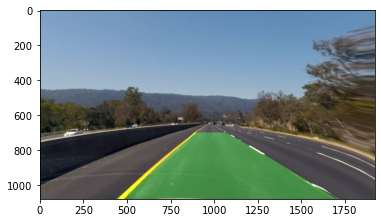

In [2]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        #Let's count the number of consecutive frames
        self.count = 0
        # was the line detected in the last iteration?
        self.detected = False  
        #polynomial coefficients for the most recent fit
        self.curve_fit = []  
        # Traking variance for the right lane
        self.variance = []
        #difference in fit coefficients between last and new fits. Just store the difference in coefficients for the last frame
        self.coeff_diff = [[0,0,0],[0,0,0]]        
        #Lane width measured at the start of reset
        self.lane_width = 0
        #Let's track the midpoint of the previous frame
        self.lane_bottom_centre = 0
        
        # x values of the curve that we fit intially
        #self.current_xfitted = []
        # x values for detected line pixels
        #self.allx = []  
        # y values for detected line pixels
        #self.ally = []
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        
        
lane=Line()


frame1= mpimg.imread("my_test_images/Highway_snaps/image (1).jpg")
frame2= mpimg.imread("my_test_images/Highway_snaps/image (2).jpg")
frame3= mpimg.imread("my_test_images/Highway_snaps/image (3).jpg")

frame4= mpimg.imread("my_test_images/Highway_snaps/image (4).jpg")
frame5= mpimg.imread("my_test_images/Highway_snaps/image (5).jpg")
frame6= mpimg.imread("my_test_images/Highway_snaps/image (6).jpg")
frame7= mpimg.imread("my_test_images/Highway_snaps/image (7).jpg")
frame8= mpimg.imread("my_test_images/Highway_snaps/image (8).jpg")
frame9= mpimg.imread("my_test_images/Highway_snaps/image (9).jpg")


(process_image(frame1))
(process_image(frame2))
(process_image(frame3))
(process_image(frame4))
(process_image(frame5))
(process_image(frame6))
(process_image(frame7))
(process_image(frame8))
plt.imshow(process_image(frame9))


In [16]:
matrix = [[[-8.8661072804927e-05, 0.14226773448007834, 526.2761730836886], [-8.8661072804927e-05, 0.14226773448007834, 526.2761730836886], [-8.8661072804927e-05, 0.14226773448007834, 526.2761730836886], [-8.8661072804927e-05, 0.14226773448007834, 526.2761730836886], [-8.8661072804927e-05, 0.14226773448007837, 526.2761730836886]], [[-0.0001476233231556424, 0.23167536974077843, 1331.6306119167443], [-0.0001476233231556424, 0.23167536974077843, 1331.6306119167443], [-0.0001476233231556424, 0.23167536974077843, 1331.6306119167443], [-0.0001476233231556424, 0.23167536974077843, 1331.6306119167443], [-0.0001476233231556424, 0.23167536974077843, 1331.6306119167443]]]
matrix[1]

[[-0.0001476233231556424, 0.23167536974077843, 1331.6306119167443],
 [-0.0001476233231556424, 0.23167536974077843, 1331.6306119167443],
 [-0.0001476233231556424, 0.23167536974077843, 1331.6306119167443],
 [-0.0001476233231556424, 0.23167536974077843, 1331.6306119167443],
 [-0.0001476233231556424, 0.23167536974077843, 1331.6306119167443]]

Videoo test



In [6]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        #Let's count the number of consecutive frames
        self.count = 0
        # was the line detected in the last iteration?
        self.detected = False  
        #polynomial coefficients for the most recent fit
        self.curve_fit = []  
        # Traking variance for the right lane
        self.variance = []
        #difference in fit coefficients between last and new fits. Just store the difference in coefficients for the last frame
        self.coeff_diff = [[0,0,0],[0,0,0]]       
        #Lane width measured at the start of reset
        self.lane_width = 0
        #Let's track the midpoint of the previous frame
        self.lane_bottom_centre = 0
        
        
        # x values of the curve that we fit intially
        #self.current_xfitted = []
        # x values for detected line pixels
        #self.allx = []  
        # y values for detected line pixels
        #self.ally = []
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
lane=Line()

project_output = 'output_files/video_clips/project_video_with_history.mp4'

#clip1 = VideoFileClip("project_video.mp4")
clip1 = VideoFileClip("project_video.mp4").subclip(15,25)

project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images! 
%time project_clip.write_videofile(project_output, audio=False)

starting count 0


t:   0%|          | 0/250 [00:00<?, ?it/s, now=None]

lane.lane_width 611.9654132720186
lane.lane_bottom_centre 668.2284488960955
Moviepy - Building video output_files/video_clips/project_video_with_history.mp4.
Moviepy - Writing video output_files/video_clips/project_video_with_history.mp4

starting count 1


t:   1%|          | 2/250 [00:00<01:38,  2.51it/s, now=None]

lane.lane_width 611.9654132720187
lane.lane_bottom_centre 668.2284488960955
starting count 2


t:   1%|          | 3/250 [00:01<02:21,  1.75it/s, now=None]

lane.lane_width 611.3225157903094
lane.lane_bottom_centre 668.2284488960956
starting count 3
lane.lane_width 611.5770633826388
lane.lane_bottom_centre 668.2284488960956


t:   2%|▏         | 4/250 [00:04<04:56,  1.21s/it, now=None]

starting count 4


t:   2%|▏         | 5/250 [00:05<05:00,  1.23s/it, now=None]

lane.lane_width 613.1420557800126
lane.lane_bottom_centre 668.2284488960956
starting count 5


t:   2%|▏         | 6/250 [00:06<04:38,  1.14s/it, now=None]

lane.lane_width 613.8847650207889
lane.lane_bottom_centre 668.2284488960956
starting count 6


t:   3%|▎         | 7/250 [00:07<04:29,  1.11s/it, now=None]

lane.lane_width 614.7220155941116
lane.lane_bottom_centre 668.2284488960956
starting count 7


t:   3%|▎         | 8/250 [00:10<06:55,  1.72s/it, now=None]

lane.lane_width 615.4639498007798
lane.lane_bottom_centre 668.2284488960956
starting count 8


t:   4%|▎         | 9/250 [00:11<06:00,  1.50s/it, now=None]

lane.lane_width 615.8776629323819
lane.lane_bottom_centre 668.2284488960958
starting count 9


t:   4%|▍         | 10/250 [00:12<05:22,  1.34s/it, now=None]

lane.lane_width 616.2457145058031
lane.lane_bottom_centre 668.2284488960958
starting count 10


t:   4%|▍         | 11/250 [00:13<04:42,  1.18s/it, now=None]

lane.lane_width 616.6726230614062
lane.lane_bottom_centre 668.2284488960958
starting count 11
lane.lane_width 617.0700973996171
lane.lane_bottom_centre 668.2284488960958


t:   5%|▍         | 12/250 [00:16<06:24,  1.61s/it, now=None]

starting count 12


t:   5%|▌         | 13/250 [00:18<06:55,  1.75s/it, now=None]

lane.lane_width 617.3368045605591
lane.lane_bottom_centre 668.2284488960958
starting count 13


t:   6%|▌         | 14/250 [00:19<05:45,  1.46s/it, now=None]

lane.lane_width 618.3401266513613
lane.lane_bottom_centre 668.2284488960958
starting count 14


t:   6%|▌         | 15/250 [00:22<07:44,  1.98s/it, now=None]

lane.lane_width 618.7365278199221
lane.lane_bottom_centre 668.2284488960958
starting count 15


t:   6%|▋         | 16/250 [00:23<06:26,  1.65s/it, now=None]

lane.lane_width 618.8404185152624
lane.lane_bottom_centre 668.2284488960958
starting count 16


t:   7%|▋         | 17/250 [00:24<05:39,  1.46s/it, now=None]

lane.lane_width 619.172197500877
lane.lane_bottom_centre 668.2284488960958
starting count 17


t:   7%|▋         | 18/250 [00:28<08:30,  2.20s/it, now=None]

lane.lane_width 619.1527922824371
lane.lane_bottom_centre 668.2284488960958
starting count 18


t:   8%|▊         | 19/250 [00:29<07:26,  1.93s/it, now=None]

lane.lane_width 619.0981059868498
lane.lane_bottom_centre 668.2284488960958
starting count 19


t:   8%|▊         | 20/250 [00:34<10:27,  2.73s/it, now=None]

lane.lane_width 619.5732601889274
lane.lane_bottom_centre 668.2284488960959
starting count 20


t:   8%|▊         | 21/250 [00:35<08:59,  2.36s/it, now=None]

lane.lane_width 619.7426310898
lane.lane_bottom_centre 668.2284488960959
starting count 21


t:   9%|▉         | 22/250 [00:36<07:18,  1.92s/it, now=None]

lane.lane_width 620.0775964455121
lane.lane_bottom_centre 668.2284488960958
starting count 22


t:   9%|▉         | 23/250 [00:40<09:59,  2.64s/it, now=None]

lane.lane_width 620.1459396191483
lane.lane_bottom_centre 668.2284488960956
starting count 23
lane.lane_width 620.2033571064877
lane.lane_bottom_centre 668.2284488960955


t:  10%|▉         | 24/250 [00:42<09:13,  2.45s/it, now=None]

starting count 24


t:  10%|█         | 25/250 [00:45<09:49,  2.62s/it, now=None]

lane.lane_width 620.0525560977119
lane.lane_bottom_centre 668.2284488960955
starting count 25


t:  10%|█         | 26/250 [00:46<07:48,  2.09s/it, now=None]

lane.lane_width 619.921122718207
lane.lane_bottom_centre 668.2284488960954
starting count 26


t:  11%|█         | 27/250 [00:47<06:19,  1.70s/it, now=None]

lane.lane_width 620.2595718078145
lane.lane_bottom_centre 668.2284488960954
starting count 27


t:  11%|█         | 28/250 [00:50<07:52,  2.13s/it, now=None]

lane.lane_width 620.435481414435
lane.lane_bottom_centre 668.2284488960954
starting count 28


t:  12%|█▏        | 29/250 [00:51<06:25,  1.74s/it, now=None]

lane.lane_width 620.4970681409443
lane.lane_bottom_centre 668.2284488960954
starting count 29


t:  12%|█▏        | 30/250 [00:52<05:25,  1.48s/it, now=None]

lane.lane_width 620.61799133617
lane.lane_bottom_centre 668.2284488960954
starting count 30


t:  12%|█▏        | 31/250 [00:53<04:47,  1.31s/it, now=None]

lane.lane_width 620.5040733892735
lane.lane_bottom_centre 668.2284488960954
starting count 31


t:  13%|█▎        | 32/250 [00:56<07:28,  2.06s/it, now=None]

lane.lane_width 620.5831851830794
lane.lane_bottom_centre 668.2284488960954
starting count 32


t:  13%|█▎        | 33/250 [00:57<06:08,  1.70s/it, now=None]

lane.lane_width 620.8151850665929
lane.lane_bottom_centre 668.2284488960954
starting count 33


t:  14%|█▎        | 34/250 [00:58<05:11,  1.44s/it, now=None]

lane.lane_width 620.8116162739766
lane.lane_bottom_centre 668.2284488960954
starting count 34


t:  14%|█▍        | 35/250 [01:01<07:08,  1.99s/it, now=None]

lane.lane_width 620.861609388641
lane.lane_bottom_centre 668.2284488960954
starting count 35


t:  14%|█▍        | 36/250 [01:02<05:54,  1.66s/it, now=None]

lane.lane_width 620.7593275664802
lane.lane_bottom_centre 668.2284488960954
starting count 36


t:  15%|█▍        | 37/250 [01:03<04:59,  1.41s/it, now=None]

lane.lane_width 620.7410003794795
lane.lane_bottom_centre 668.2284488960954
starting count 37


t:  15%|█▌        | 38/250 [01:04<04:19,  1.22s/it, now=None]

lane.lane_width 620.6964314304754
lane.lane_bottom_centre 668.2284488960954
starting count 38


t:  16%|█▌        | 39/250 [01:08<07:13,  2.06s/it, now=None]

lane.lane_width 621.0047466744794
lane.lane_bottom_centre 668.2284488960954
starting count 39


t:  16%|█▌        | 40/250 [01:09<06:18,  1.80s/it, now=None]

lane.lane_width 621.2528411359915
lane.lane_bottom_centre 668.2284488960954
starting count 40


t:  16%|█▋        | 41/250 [01:14<09:42,  2.79s/it, now=None]

lane.lane_width 621.1913459855282
lane.lane_bottom_centre 668.2284488960954
starting count 41


t:  17%|█▋        | 42/250 [01:15<08:05,  2.34s/it, now=None]

lane.lane_width 621.2794620833445
lane.lane_bottom_centre 668.2284488960954
starting count 42


t:  17%|█▋        | 43/250 [01:20<10:09,  2.94s/it, now=None]

lane.lane_width 621.3590830120866
lane.lane_bottom_centre 668.2284488960954
starting count 43


t:  18%|█▊        | 44/250 [01:21<08:27,  2.46s/it, now=None]

lane.lane_width 621.4644566071778
lane.lane_bottom_centre 668.2284488960954
starting count 44


t:  18%|█▊        | 45/250 [01:25<09:39,  2.83s/it, now=None]

lane.lane_width 621.5146240736116
lane.lane_bottom_centre 668.2284488960955
starting count 45


t:  18%|█▊        | 46/250 [01:26<07:43,  2.27s/it, now=None]

lane.lane_width 621.521882754061
lane.lane_bottom_centre 668.2284488960955
starting count 46


t:  19%|█▉        | 47/250 [01:27<06:19,  1.87s/it, now=None]

lane.lane_width 621.5472369635866
lane.lane_bottom_centre 668.2284488960955
starting count 47


t:  19%|█▉        | 48/250 [01:31<08:26,  2.51s/it, now=None]

lane.lane_width 621.5582315158889
lane.lane_bottom_centre 668.2284488960955
starting count 48


t:  20%|█▉        | 49/250 [01:32<06:42,  2.00s/it, now=None]

lane.lane_width 621.5387800407042
lane.lane_bottom_centre 668.2284488960955
starting count 49


t:  20%|██        | 50/250 [01:32<05:29,  1.65s/it, now=None]

lane.lane_width 621.5066874708589
lane.lane_bottom_centre 668.2284488960955
starting count 50


t:  20%|██        | 51/250 [01:33<04:40,  1.41s/it, now=None]

lane.lane_width 621.6247490483388
lane.lane_bottom_centre 668.2284488960955
starting count 51


t:  21%|██        | 52/250 [01:37<06:54,  2.09s/it, now=None]

lane.lane_width 621.7276368579268
lane.lane_bottom_centre 668.2284488960954
starting count 52


t:  21%|██        | 53/250 [01:38<05:39,  1.73s/it, now=None]

lane.lane_width 621.8210314695568
lane.lane_bottom_centre 668.2284488960954
starting count 53


t:  22%|██▏       | 54/250 [01:39<04:55,  1.51s/it, now=None]

lane.lane_width 621.8990269593619
lane.lane_bottom_centre 668.2284488960954
starting count 54


t:  22%|██▏       | 55/250 [01:43<07:11,  2.21s/it, now=None]

lane.lane_width 621.8497414004156
lane.lane_bottom_centre 668.2284488960954
starting count 55


t:  22%|██▏       | 56/250 [01:44<05:50,  1.81s/it, now=None]

lane.lane_width 621.7626219651104
lane.lane_bottom_centre 668.2284488960954
starting count 56


t:  23%|██▎       | 57/250 [01:44<04:57,  1.54s/it, now=None]

lane.lane_width 621.7156672196215
lane.lane_bottom_centre 668.2284488960954
starting count 57


t:  23%|██▎       | 58/250 [01:48<06:33,  2.05s/it, now=None]

lane.lane_width 621.7139356743091
lane.lane_bottom_centre 668.2284488960954
starting count 58


t:  24%|██▎       | 59/250 [01:49<05:22,  1.69s/it, now=None]

lane.lane_width 621.6949314346858
lane.lane_bottom_centre 668.2284488960954
starting count 59


t:  24%|██▍       | 60/250 [01:49<04:33,  1.44s/it, now=None]

lane.lane_width 621.6232688542513
lane.lane_bottom_centre 668.2284488960954
starting count 60


t:  24%|██▍       | 61/250 [01:50<04:07,  1.31s/it, now=None]

lane.lane_width 621.6369495781313
lane.lane_bottom_centre 668.2284488960954
starting count 61


t:  25%|██▍       | 62/250 [01:54<06:23,  2.04s/it, now=None]

lane.lane_width 621.5568367826666
lane.lane_bottom_centre 668.2284488960954
starting count 62


t:  25%|██▌       | 63/250 [01:55<05:24,  1.73s/it, now=None]

lane.lane_width 621.6692486079145
lane.lane_bottom_centre 668.2284488960954
starting count 63


t:  26%|██▌       | 64/250 [01:56<04:45,  1.54s/it, now=None]

lane.lane_width 621.759871526681
lane.lane_bottom_centre 668.2284488960954
starting count 64


t:  26%|██▌       | 65/250 [02:00<06:47,  2.20s/it, now=None]

lane.lane_width 621.8534513996885
lane.lane_bottom_centre 668.2284488960954
starting count 65


t:  26%|██▋       | 66/250 [02:01<05:31,  1.80s/it, now=None]

lane.lane_width 621.8958548483196
lane.lane_bottom_centre 668.2284488960954
starting count 66


t:  27%|██▋       | 67/250 [02:02<04:37,  1.52s/it, now=None]

lane.lane_width 621.8790272521059
lane.lane_bottom_centre 668.2284488960954
starting count 67


t:  27%|██▋       | 68/250 [02:05<06:36,  2.18s/it, now=None]

lane.lane_width 621.8688761907445
lane.lane_bottom_centre 668.2284488960954
starting count 68


t:  28%|██▊       | 69/250 [02:06<05:29,  1.82s/it, now=None]

lane.lane_width 621.8638027373709
lane.lane_bottom_centre 668.2284488960954
starting count 69


t:  28%|██▊       | 70/250 [02:11<08:12,  2.73s/it, now=None]

lane.lane_width 621.9044554275189
lane.lane_bottom_centre 668.2284488960954
starting count 70


t:  28%|██▊       | 71/250 [02:12<06:38,  2.23s/it, now=None]

lane.lane_width 621.8343030982924
lane.lane_bottom_centre 668.2284488960954
starting count 71


t:  29%|██▉       | 72/250 [02:13<05:23,  1.82s/it, now=None]

lane.lane_width 621.8682121423172
lane.lane_bottom_centre 668.2284488960954
starting count 72


t:  29%|██▉       | 73/250 [02:14<04:31,  1.53s/it, now=None]

lane.lane_width 621.8160771398009
lane.lane_bottom_centre 668.2284488960954
starting count 73


t:  30%|██▉       | 74/250 [02:18<06:24,  2.19s/it, now=None]

lane.lane_width 621.9445862984853
lane.lane_bottom_centre 668.2284488960954
starting count 74


t:  30%|███       | 75/250 [02:19<05:14,  1.80s/it, now=None]

lane.lane_width 622.0460436508528
lane.lane_bottom_centre 668.2284488960954
starting count 75


t:  30%|███       | 76/250 [02:20<04:24,  1.52s/it, now=None]

lane.lane_width 622.0890137876121
lane.lane_bottom_centre 668.2284488960954
starting count 76


t:  31%|███       | 77/250 [02:23<05:54,  2.05s/it, now=None]

lane.lane_width 622.1595263036015
lane.lane_bottom_centre 668.2284488960954
starting count 77


t:  31%|███       | 78/250 [02:24<04:52,  1.70s/it, now=None]

lane.lane_width 622.2402220997686
lane.lane_bottom_centre 668.2284488960954
starting count 78


t:  32%|███▏      | 79/250 [02:25<04:09,  1.46s/it, now=None]

lane.lane_width 622.2798564549756
lane.lane_bottom_centre 668.2284488960954
starting count 79


t:  32%|███▏      | 80/250 [02:26<03:38,  1.29s/it, now=None]

lane.lane_width 622.3191397323196
lane.lane_bottom_centre 668.2284488960954
starting count 80


t:  32%|███▏      | 81/250 [02:29<05:40,  2.02s/it, now=None]

lane.lane_width 622.3333554094854
lane.lane_bottom_centre 668.2284488960954
starting count 81


t:  33%|███▎      | 82/250 [02:30<04:40,  1.67s/it, now=None]

lane.lane_width 622.2940117123693
lane.lane_bottom_centre 668.2284488960954
starting count 82


t:  33%|███▎      | 83/250 [02:31<04:00,  1.44s/it, now=None]

lane.lane_width 622.270007987878
lane.lane_bottom_centre 668.2284488960954
starting count 83


t:  34%|███▎      | 84/250 [02:35<06:03,  2.19s/it, now=None]

lane.lane_width 622.2621618621326
lane.lane_bottom_centre 668.2284488960954
starting count 84


t:  34%|███▍      | 85/250 [02:36<05:01,  1.83s/it, now=None]

lane.lane_width 622.2349892701578
lane.lane_bottom_centre 668.2284488960954
starting count 85


t:  34%|███▍      | 86/250 [02:37<04:13,  1.55s/it, now=None]

lane.lane_width 622.2442149686553
lane.lane_bottom_centre 668.2284488960954
starting count 86


t:  35%|███▍      | 87/250 [02:40<05:37,  2.07s/it, now=None]

lane.lane_width 622.2639730733077
lane.lane_bottom_centre 668.2284488960954
starting count 87


t:  35%|███▌      | 88/250 [02:41<04:38,  1.72s/it, now=None]

lane.lane_width 622.2985286658017
lane.lane_bottom_centre 668.2284488960954
starting count 88


t:  36%|███▌      | 89/250 [02:42<03:57,  1.47s/it, now=None]

lane.lane_width 622.3649269441804
lane.lane_bottom_centre 668.2284488960954
starting count 89


t:  36%|███▌      | 90/250 [02:43<03:28,  1.30s/it, now=None]

lane.lane_width 622.4227006467722
lane.lane_bottom_centre 668.2284488960954
starting count 90


t:  36%|███▋      | 91/250 [02:47<05:25,  2.05s/it, now=None]

lane.lane_width 622.479316588492
lane.lane_bottom_centre 668.2284488960955
starting count 91


t:  37%|███▋      | 92/250 [02:48<04:37,  1.76s/it, now=None]

lane.lane_width 622.5173644115633
lane.lane_bottom_centre 668.2284488960954
starting count 92


t:  37%|███▋      | 93/250 [02:52<06:30,  2.49s/it, now=None]

lane.lane_width 622.5577868572313
lane.lane_bottom_centre 668.2284488960954
starting count 93


t:  38%|███▊      | 94/250 [02:53<05:16,  2.03s/it, now=None]

lane.lane_width 622.5645792875787
lane.lane_bottom_centre 668.2284488960954
starting count 94


t:  38%|███▊      | 95/250 [02:54<04:33,  1.77s/it, now=None]

lane.lane_width 622.5866001563375
lane.lane_bottom_centre 668.2284488960954
starting count 95


t:  38%|███▊      | 96/250 [02:58<06:29,  2.53s/it, now=None]

lane.lane_width 622.653618650136
lane.lane_bottom_centre 668.2284488960954
starting count 96


t:  39%|███▉      | 97/250 [02:59<05:25,  2.12s/it, now=None]

lane.lane_width 622.670947460084
lane.lane_bottom_centre 668.2284488960954
starting count 97
lane.lane_width 622.6858897697916
lane.lane_bottom_centre 668.2284488960954


t:  39%|███▉      | 98/250 [03:03<06:31,  2.57s/it, now=None]

starting count 98


t:  40%|███▉      | 99/250 [03:04<05:22,  2.13s/it, now=None]

lane.lane_width 622.7929869775363
lane.lane_bottom_centre 668.2284488960953
starting count 99


t:  40%|████      | 100/250 [03:06<04:46,  1.91s/it, now=None]

lane.lane_width 622.9404730312004
lane.lane_bottom_centre 668.2284488960953
starting count 100


t:  40%|████      | 101/250 [03:10<06:36,  2.66s/it, now=None]

lane.lane_width 622.989185274296
lane.lane_bottom_centre 668.2284488960952
starting count 101


t:  41%|████      | 102/250 [03:11<05:16,  2.14s/it, now=None]

lane.lane_width 622.9889816222551
lane.lane_bottom_centre 668.2284488960952
starting count 102


t:  41%|████      | 103/250 [03:15<06:44,  2.75s/it, now=None]

lane.lane_width 622.9680756479567
lane.lane_bottom_centre 668.2284488960952
starting count 103


t:  42%|████▏     | 104/250 [03:16<05:22,  2.21s/it, now=None]

lane.lane_width 622.9689399921947
lane.lane_bottom_centre 668.2284488960952
starting count 104


t:  42%|████▏     | 105/250 [03:17<04:29,  1.86s/it, now=None]

lane.lane_width 622.9897406431728
lane.lane_bottom_centre 668.2284488960952
starting count 105


t:  42%|████▏     | 106/250 [03:21<05:53,  2.45s/it, now=None]

lane.lane_width 623.0062896434595
lane.lane_bottom_centre 668.2284488960952
starting count 106


t:  43%|████▎     | 107/250 [03:22<04:59,  2.09s/it, now=None]

lane.lane_width 622.951447174276
lane.lane_bottom_centre 668.2284488960952
starting count 107


t:  43%|████▎     | 108/250 [03:26<06:31,  2.76s/it, now=None]

lane.lane_width 622.935734809014
lane.lane_bottom_centre 668.2284488960952
starting count 108


t:  44%|████▎     | 109/250 [03:27<05:12,  2.22s/it, now=None]

lane.lane_width 623.0603161058804
lane.lane_bottom_centre 668.2284488960952
starting count 109


t:  44%|████▍     | 110/250 [03:28<04:14,  1.82s/it, now=None]

lane.lane_width 623.0587701170363
lane.lane_bottom_centre 668.2284488960952
starting count 110


t:  44%|████▍     | 111/250 [03:29<03:31,  1.52s/it, now=None]

lane.lane_width 623.1391011381698
lane.lane_bottom_centre 668.2284488960952
starting count 111


t:  45%|████▍     | 112/250 [03:33<05:03,  2.20s/it, now=None]

lane.lane_width 623.1991383836148
lane.lane_bottom_centre 668.2284488960952
starting count 112


t:  45%|████▌     | 113/250 [03:34<04:08,  1.81s/it, now=None]

lane.lane_width 623.2771887279409
lane.lane_bottom_centre 668.2284488960952
starting count 113


t:  46%|████▌     | 114/250 [03:35<03:33,  1.57s/it, now=None]

lane.lane_width 623.32907858576
lane.lane_bottom_centre 668.2284488960952
starting count 114


t:  46%|████▌     | 115/250 [03:39<05:08,  2.29s/it, now=None]

lane.lane_width 623.3658293289864
lane.lane_bottom_centre 668.2284488960952
starting count 115


t:  46%|████▋     | 116/250 [03:40<04:12,  1.88s/it, now=None]

lane.lane_width 623.3928589085394
lane.lane_bottom_centre 668.2284488960952
starting count 116


t:  47%|████▋     | 117/250 [03:41<03:38,  1.64s/it, now=None]

lane.lane_width 623.3893084298485
lane.lane_bottom_centre 668.2284488960951
starting count 117


t:  47%|████▋     | 118/250 [03:45<04:59,  2.27s/it, now=None]

lane.lane_width 623.3575348440631
lane.lane_bottom_centre 668.228448896095
starting count 118


t:  48%|████▊     | 119/250 [03:45<04:04,  1.86s/it, now=None]

lane.lane_width 623.3977208813566
lane.lane_bottom_centre 668.228448896095
starting count 119


t:  48%|████▊     | 120/250 [03:46<03:25,  1.58s/it, now=None]

lane.lane_width 623.4529769328664
lane.lane_bottom_centre 668.228448896095
starting count 120


t:  48%|████▊     | 121/250 [03:50<04:36,  2.14s/it, now=None]

lane.lane_width 623.5190261022822
lane.lane_bottom_centre 668.228448896095
starting count 121


t:  49%|████▉     | 122/250 [03:51<04:03,  1.90s/it, now=None]

lane.lane_width 623.6090100976977
lane.lane_bottom_centre 668.228448896095
starting count 122


t:  49%|████▉     | 123/250 [03:52<03:32,  1.68s/it, now=None]

lane.lane_width 623.7394011886288
lane.lane_bottom_centre 668.228448896095
starting count 123


t:  50%|████▉     | 124/250 [03:57<05:11,  2.47s/it, now=None]

lane.lane_width 623.8070905644109
lane.lane_bottom_centre 668.228448896095
starting count 124


t:  50%|█████     | 125/250 [03:58<04:16,  2.05s/it, now=None]

lane.lane_width 623.9160088729758
lane.lane_bottom_centre 668.228448896095
starting count 125


t:  50%|█████     | 126/250 [04:01<05:02,  2.44s/it, now=None]

lane.lane_width 624.0373046146285
lane.lane_bottom_centre 668.228448896095
starting count 126


t:  51%|█████     | 127/250 [04:02<04:14,  2.07s/it, now=None]

lane.lane_width 624.1323531681408
lane.lane_bottom_centre 668.228448896095
starting count 127


t:  51%|█████     | 128/250 [04:03<03:31,  1.74s/it, now=None]

lane.lane_width 624.1870039092094
lane.lane_bottom_centre 668.228448896095
starting count 128


t:  52%|█████▏    | 129/250 [04:07<04:44,  2.35s/it, now=None]

lane.lane_width 624.22697936571
lane.lane_bottom_centre 668.228448896095
starting count 129


t:  52%|█████▏    | 130/250 [04:08<03:57,  1.98s/it, now=None]

lane.lane_width 624.2533695438506
lane.lane_bottom_centre 668.228448896095
starting count 130


t:  52%|█████▏    | 131/250 [04:09<03:22,  1.70s/it, now=None]

lane.lane_width 624.2890976806575
lane.lane_bottom_centre 668.228448896095
starting count 131


t:  53%|█████▎    | 132/250 [04:13<04:48,  2.45s/it, now=None]

lane.lane_width 624.245120044444
lane.lane_bottom_centre 668.228448896095
starting count 132


t:  53%|█████▎    | 133/250 [04:15<04:14,  2.17s/it, now=None]

lane.lane_width 624.2770627525902
lane.lane_bottom_centre 668.228448896095
starting count 133


t:  54%|█████▎    | 134/250 [04:19<05:07,  2.65s/it, now=None]

lane.lane_width 624.3216079114347
lane.lane_bottom_centre 668.228448896095
starting count 134


t:  54%|█████▍    | 135/250 [04:20<04:03,  2.12s/it, now=None]

lane.lane_width 624.4015286198025
lane.lane_bottom_centre 668.228448896095
starting count 135


t:  54%|█████▍    | 136/250 [04:20<03:19,  1.75s/it, now=None]

lane.lane_width 624.470166503019
lane.lane_bottom_centre 668.228448896095
starting count 136


t:  55%|█████▍    | 137/250 [04:24<04:26,  2.36s/it, now=None]

lane.lane_width 624.6391506176153
lane.lane_bottom_centre 668.228448896095
starting count 137


t:  55%|█████▌    | 138/250 [04:25<03:37,  1.94s/it, now=None]

lane.lane_width 624.753324084575
lane.lane_bottom_centre 668.2284488960951
starting count 138


t:  56%|█████▌    | 139/250 [04:26<03:02,  1.65s/it, now=None]

lane.lane_width 624.8278563489953
lane.lane_bottom_centre 668.2284488960951
starting count 139


t:  56%|█████▌    | 140/250 [04:30<04:08,  2.26s/it, now=None]

lane.lane_width 624.8914118894501
lane.lane_bottom_centre 668.2284488960951
starting count 140


t:  56%|█████▋    | 141/250 [04:31<03:22,  1.85s/it, now=None]

lane.lane_width 624.9261049072182
lane.lane_bottom_centre 668.228448896095
starting count 141


t:  57%|█████▋    | 142/250 [04:32<02:49,  1.57s/it, now=None]

lane.lane_width 624.9687340172154
lane.lane_bottom_centre 668.228448896095
starting count 142
lane.lane_width 624.9823447520273
lane.lane_bottom_centre 668.228448896095


t:  57%|█████▋    | 143/250 [04:35<03:33,  2.00s/it, now=None]

starting count 143


t:  58%|█████▊    | 144/250 [04:36<03:15,  1.85s/it, now=None]

lane.lane_width 625.0483598534603
lane.lane_bottom_centre 668.2284488960948
starting count 144


t:  58%|█████▊    | 145/250 [04:37<02:43,  1.56s/it, now=None]

lane.lane_width 625.0680730227226
lane.lane_bottom_centre 668.2284488960948
starting count 145


t:  58%|█████▊    | 146/250 [04:38<02:20,  1.35s/it, now=None]

lane.lane_width 625.0830390048905
lane.lane_bottom_centre 668.2284488960947
starting count 146


t:  59%|█████▉    | 147/250 [04:41<03:26,  2.01s/it, now=None]

lane.lane_width 625.0715689985063
lane.lane_bottom_centre 668.2284488960947
starting count 147


t:  59%|█████▉    | 148/250 [04:42<02:47,  1.64s/it, now=None]

lane.lane_width 625.1709478365123
lane.lane_bottom_centre 668.2284488960947
starting count 148


t:  60%|█████▉    | 149/250 [04:43<02:22,  1.41s/it, now=None]

lane.lane_width 625.2581230653564
lane.lane_bottom_centre 668.2284488960947
starting count 149


t:  60%|██████    | 150/250 [04:44<02:05,  1.26s/it, now=None]

lane.lane_width 625.3241554204967
lane.lane_bottom_centre 668.2284488960947
starting count 150


t:  60%|██████    | 151/250 [04:48<03:18,  2.00s/it, now=None]

lane.lane_width 625.3591690610342
lane.lane_bottom_centre 668.2284488960947
starting count 151


t:  61%|██████    | 152/250 [04:49<02:44,  1.68s/it, now=None]

lane.lane_width 625.3645555518503
lane.lane_bottom_centre 668.2284488960947
starting count 152


t:  61%|██████    | 153/250 [04:50<02:24,  1.49s/it, now=None]

lane.lane_width 625.3595524173218
lane.lane_bottom_centre 668.2284488960947
starting count 153


t:  62%|██████▏   | 154/250 [04:54<03:29,  2.18s/it, now=None]

lane.lane_width 625.35448785034
lane.lane_bottom_centre 668.2284488960947
starting count 154


t:  62%|██████▏   | 155/250 [04:55<02:54,  1.84s/it, now=None]

lane.lane_width 625.3615369552025
lane.lane_bottom_centre 668.2284488960947
starting count 155


t:  62%|██████▏   | 156/250 [04:56<02:34,  1.64s/it, now=None]

lane.lane_width 625.3940860178664
lane.lane_bottom_centre 668.2284488960947
starting count 156


t:  63%|██████▎   | 157/250 [05:00<03:43,  2.40s/it, now=None]

lane.lane_width 625.4156399304163
lane.lane_bottom_centre 668.2284488960947
starting count 157


t:  63%|██████▎   | 158/250 [05:01<03:14,  2.12s/it, now=None]

lane.lane_width 625.4670741668037
lane.lane_bottom_centre 668.2284488960947
starting count 158


t:  64%|██████▎   | 159/250 [05:06<04:11,  2.76s/it, now=None]

lane.lane_width 625.4904867281934
lane.lane_bottom_centre 668.2284488960947
starting count 159


t:  64%|██████▍   | 160/250 [05:07<03:28,  2.31s/it, now=None]

lane.lane_width 625.5693399206151
lane.lane_bottom_centre 668.2284488960947
starting count 160
lane.lane_width 625.6372006446386
lane.lane_bottom_centre 668.2284488960947


t:  64%|██████▍   | 161/250 [05:10<03:42,  2.50s/it, now=None]

starting count 161


t:  65%|██████▍   | 162/250 [05:12<03:25,  2.34s/it, now=None]

lane.lane_width 625.6982766423353
lane.lane_bottom_centre 668.2284488960947
starting count 162


t:  65%|██████▌   | 163/250 [05:13<02:47,  1.93s/it, now=None]

lane.lane_width 625.7294428921309
lane.lane_bottom_centre 668.2284488960947
starting count 163


t:  66%|██████▌   | 164/250 [05:14<02:20,  1.64s/it, now=None]

lane.lane_width 625.6850872189118
lane.lane_bottom_centre 668.2284488960947
starting count 164


t:  66%|██████▌   | 165/250 [05:17<02:59,  2.11s/it, now=None]

lane.lane_width 625.6868340919295
lane.lane_bottom_centre 668.2284488960947
starting count 165


t:  66%|██████▋   | 166/250 [05:18<02:33,  1.83s/it, now=None]

lane.lane_width 625.5373753789447
lane.lane_bottom_centre 668.2284488960947
starting count 166


t:  67%|██████▋   | 167/250 [05:19<02:11,  1.58s/it, now=None]

lane.lane_width 625.5114932691688
lane.lane_bottom_centre 668.2284488960947
starting count 167


t:  67%|██████▋   | 168/250 [05:23<03:02,  2.23s/it, now=None]

lane.lane_width 625.4454561681305
lane.lane_bottom_centre 668.2284488960947
starting count 168


t:  68%|██████▊   | 169/250 [05:24<02:31,  1.87s/it, now=None]

lane.lane_width 625.4550296285223
lane.lane_bottom_centre 668.2284488960947
starting count 169


t:  68%|██████▊   | 170/250 [05:25<02:08,  1.61s/it, now=None]

lane.lane_width 625.4869125835002
lane.lane_bottom_centre 668.2284488960947
starting count 170


t:  68%|██████▊   | 171/250 [05:29<02:56,  2.24s/it, now=None]

lane.lane_width 625.562431021738
lane.lane_bottom_centre 668.2284488960947
starting count 171


t:  69%|██████▉   | 172/250 [05:30<02:25,  1.86s/it, now=None]

lane.lane_width 625.6576247793579
lane.lane_bottom_centre 668.2284488960947
starting count 172


t:  69%|██████▉   | 173/250 [05:31<02:03,  1.60s/it, now=None]

lane.lane_width 625.7046265709539
lane.lane_bottom_centre 668.2284488960947
starting count 173


t:  70%|██████▉   | 174/250 [05:35<02:55,  2.31s/it, now=None]

lane.lane_width 625.7472180699293
lane.lane_bottom_centre 668.2284488960946
starting count 174


t:  70%|███████   | 175/250 [05:36<02:29,  1.99s/it, now=None]

lane.lane_width 625.7898180052572
lane.lane_bottom_centre 668.2284488960946
starting count 175


t:  70%|███████   | 176/250 [05:37<02:06,  1.71s/it, now=None]

lane.lane_width 625.765377870129
lane.lane_bottom_centre 668.2284488960946
starting count 176


t:  71%|███████   | 177/250 [05:41<02:51,  2.35s/it, now=None]

lane.lane_width 625.7742292522832
lane.lane_bottom_centre 668.2284488960946
starting count 177


t:  71%|███████   | 178/250 [05:42<02:21,  1.96s/it, now=None]

lane.lane_width 625.7930559470745
lane.lane_bottom_centre 668.2284488960946
starting count 178


t:  72%|███████▏  | 179/250 [05:43<01:58,  1.67s/it, now=None]

lane.lane_width 625.8070132935013
lane.lane_bottom_centre 668.2284488960946
starting count 179


t:  72%|███████▏  | 180/250 [05:46<02:30,  2.15s/it, now=None]

lane.lane_width 625.8087827979167
lane.lane_bottom_centre 668.2284488960946
starting count 180


t:  72%|███████▏  | 181/250 [05:47<02:07,  1.84s/it, now=None]

lane.lane_width 625.8660924376331
lane.lane_bottom_centre 668.2284488960945
starting count 181


t:  73%|███████▎  | 182/250 [05:48<01:46,  1.57s/it, now=None]

lane.lane_width 625.90510357748
lane.lane_bottom_centre 668.2284488960945
starting count 182


t:  73%|███████▎  | 183/250 [05:52<02:29,  2.23s/it, now=None]

lane.lane_width 625.9501046860532
lane.lane_bottom_centre 668.2284488960945
starting count 183


t:  74%|███████▎  | 184/250 [05:53<02:01,  1.85s/it, now=None]

lane.lane_width 626.0131184658478
lane.lane_bottom_centre 668.2284488960945
starting count 184


t:  74%|███████▍  | 185/250 [05:54<01:43,  1.59s/it, now=None]

lane.lane_width 626.1009005202885
lane.lane_bottom_centre 668.2284488960945
starting count 185


t:  74%|███████▍  | 186/250 [05:57<02:12,  2.07s/it, now=None]

lane.lane_width 626.2508951127616
lane.lane_bottom_centre 668.2284488960945
starting count 186


t:  75%|███████▍  | 187/250 [05:58<01:46,  1.69s/it, now=None]

lane.lane_width 626.3527043255879
lane.lane_bottom_centre 668.2284488960945
starting count 187


t:  75%|███████▌  | 188/250 [05:59<01:27,  1.41s/it, now=None]

lane.lane_width 626.4449388383172
lane.lane_bottom_centre 668.2284488960945
starting count 188


t:  76%|███████▌  | 189/250 [05:59<01:17,  1.27s/it, now=None]

lane.lane_width 626.5747799884398
lane.lane_bottom_centre 668.2284488960945
starting count 189


t:  76%|███████▌  | 190/250 [06:03<01:59,  1.99s/it, now=None]

lane.lane_width 626.6974551600734
lane.lane_bottom_centre 668.2284488960945
starting count 190


t:  76%|███████▋  | 191/250 [06:04<01:39,  1.68s/it, now=None]

lane.lane_width 626.681591124018
lane.lane_bottom_centre 668.2284488960945
starting count 191


t:  77%|███████▋  | 192/250 [06:05<01:21,  1.41s/it, now=None]

lane.lane_width 626.7108650991205
lane.lane_bottom_centre 668.2284488960944
starting count 192


t:  77%|███████▋  | 193/250 [06:06<01:09,  1.23s/it, now=None]

lane.lane_width 626.7230598975689
lane.lane_bottom_centre 668.2284488960943
starting count 193


t:  78%|███████▊  | 194/250 [06:09<01:49,  1.95s/it, now=None]

lane.lane_width 626.8588629869678
lane.lane_bottom_centre 668.2284488960943
starting count 194


t:  78%|███████▊  | 195/250 [06:10<01:29,  1.63s/it, now=None]

lane.lane_width 626.9519618662382
lane.lane_bottom_centre 668.2284488960943
starting count 195


t:  78%|███████▊  | 196/250 [06:11<01:15,  1.40s/it, now=None]

lane.lane_width 627.021506220141
lane.lane_bottom_centre 668.2284488960943
starting count 196


t:  79%|███████▉  | 197/250 [06:15<01:51,  2.11s/it, now=None]

lane.lane_width 627.1211124641774
lane.lane_bottom_centre 668.2284488960943
starting count 197


t:  79%|███████▉  | 198/250 [06:16<01:29,  1.72s/it, now=None]

lane.lane_width 627.1671239780444
lane.lane_bottom_centre 668.2284488960943
starting count 198


t:  80%|███████▉  | 199/250 [06:16<01:13,  1.44s/it, now=None]

lane.lane_width 627.212301869929
lane.lane_bottom_centre 668.2284488960943
starting count 199
lane.lane_width 627.2743713430343
lane.lane_bottom_centre 668.2284488960943


t:  80%|████████  | 200/250 [06:18<01:07,  1.36s/it, now=None]

starting count 200


t:  80%|████████  | 201/250 [06:20<01:29,  1.82s/it, now=None]

lane.lane_width 627.3469243599702
lane.lane_bottom_centre 668.2284488960943
starting count 201


t:  81%|████████  | 202/250 [06:21<01:10,  1.47s/it, now=None]

lane.lane_width 627.4627863170765
lane.lane_bottom_centre 668.2284488960943
starting count 202


t:  81%|████████  | 203/250 [06:22<00:56,  1.20s/it, now=None]

lane.lane_width 627.523754614303
lane.lane_bottom_centre 668.2284488960943
starting count 203


t:  82%|████████▏ | 204/250 [06:22<00:47,  1.04s/it, now=None]

lane.lane_width 627.5570488156078
lane.lane_bottom_centre 668.2284488960943
starting count 204
lane.lane_width 627.6078660007931
lane.lane_bottom_centre 668.2284488960943


t:  82%|████████▏ | 205/250 [06:24<00:53,  1.19s/it, now=None]

starting count 205


t:  82%|████████▏ | 206/250 [06:26<01:10,  1.60s/it, now=None]

lane.lane_width 627.6589780398917
lane.lane_bottom_centre 668.2284488960943
starting count 206


t:  83%|████████▎ | 207/250 [06:27<01:00,  1.40s/it, now=None]

lane.lane_width 627.7068008871685
lane.lane_bottom_centre 668.2284488960943
starting count 207


t:  83%|████████▎ | 208/250 [06:28<00:51,  1.23s/it, now=None]

lane.lane_width 627.7503528935727
lane.lane_bottom_centre 668.2284488960943
starting count 208


t:  84%|████████▎ | 209/250 [06:29<00:43,  1.06s/it, now=None]

lane.lane_width 627.8002905484741
lane.lane_bottom_centre 668.2284488960943
starting count 209


t:  84%|████████▍ | 210/250 [06:32<01:10,  1.76s/it, now=None]

lane.lane_width 627.8351077864836
lane.lane_bottom_centre 668.2284488960943
starting count 210


t:  84%|████████▍ | 211/250 [06:33<00:54,  1.41s/it, now=None]

lane.lane_width 627.850197514681
lane.lane_bottom_centre 668.2284488960943
starting count 211


t:  85%|████████▍ | 212/250 [06:33<00:43,  1.14s/it, now=None]

lane.lane_width 627.8586484027732
lane.lane_bottom_centre 668.2284488960944
starting count 212


t:  85%|████████▌ | 213/250 [06:34<00:36,  1.03it/s, now=None]

lane.lane_width 627.8612224314661
lane.lane_bottom_centre 668.2284488960945
starting count 213


t:  86%|████████▌ | 214/250 [06:34<00:30,  1.18it/s, now=None]

lane.lane_width 627.8742690197221
lane.lane_bottom_centre 668.2284488960945
starting count 214


t:  86%|████████▌ | 215/250 [06:38<00:56,  1.60s/it, now=None]

lane.lane_width 627.9609196826557
lane.lane_bottom_centre 668.2284488960945
starting count 215


t:  86%|████████▋ | 216/250 [06:38<00:43,  1.29s/it, now=None]

lane.lane_width 628.0085484681869
lane.lane_bottom_centre 668.2284488960945
starting count 216


t:  87%|████████▋ | 217/250 [06:39<00:36,  1.10s/it, now=None]

lane.lane_width 628.1237307159589
lane.lane_bottom_centre 668.2284488960945
starting count 217


t:  87%|████████▋ | 218/250 [06:40<00:30,  1.03it/s, now=None]

lane.lane_width 628.1315001327551
lane.lane_bottom_centre 668.2284488960945
starting count 218


t:  88%|████████▊ | 219/250 [06:40<00:27,  1.14it/s, now=None]

lane.lane_width 628.1696519043843
lane.lane_bottom_centre 668.2284488960945
starting count 219


t:  88%|████████▊ | 220/250 [06:43<00:45,  1.51s/it, now=None]

lane.lane_width 628.2100906028348
lane.lane_bottom_centre 668.2284488960946
starting count 220


t:  88%|████████▊ | 221/250 [06:44<00:36,  1.26s/it, now=None]

lane.lane_width 628.2128204832019
lane.lane_bottom_centre 668.2284488960946
starting count 221


t:  89%|████████▉ | 222/250 [06:45<00:29,  1.07s/it, now=None]

lane.lane_width 628.3512686373168
lane.lane_bottom_centre 668.2284488960945
starting count 222


t:  89%|████████▉ | 223/250 [06:45<00:24,  1.08it/s, now=None]

lane.lane_width 628.3563318203393
lane.lane_bottom_centre 668.2284488960945
starting count 223


t:  90%|████████▉ | 224/250 [06:46<00:21,  1.22it/s, now=None]

lane.lane_width 628.3895111310919
lane.lane_bottom_centre 668.2284488960945
starting count 224


t:  90%|█████████ | 225/250 [06:49<00:40,  1.60s/it, now=None]

lane.lane_width 628.4186044706854
lane.lane_bottom_centre 668.2284488960945
starting count 225


t:  90%|█████████ | 226/250 [06:50<00:31,  1.31s/it, now=None]

lane.lane_width 628.4431178019119
lane.lane_bottom_centre 668.2284488960944
starting count 226


t:  91%|█████████ | 227/250 [06:51<00:25,  1.11s/it, now=None]

lane.lane_width 628.4677719936309
lane.lane_bottom_centre 668.2284488960944
starting count 227


t:  91%|█████████ | 228/250 [06:51<00:21,  1.04it/s, now=None]

lane.lane_width 628.4936603134944
lane.lane_bottom_centre 668.2284488960944
starting count 228
lane.lane_width 628.5007357685793
lane.lane_bottom_centre 668.2284488960943


t:  92%|█████████▏| 229/250 [06:55<00:35,  1.69s/it, now=None]

starting count 229


t:  92%|█████████▏| 230/250 [06:55<00:27,  1.36s/it, now=None]

lane.lane_width 628.6251330125488
lane.lane_bottom_centre 668.2284488960943
starting count 230


t:  92%|█████████▏| 231/250 [06:56<00:21,  1.14s/it, now=None]

lane.lane_width 628.6322005701543
lane.lane_bottom_centre 668.2284488960943
starting count 231


t:  93%|█████████▎| 232/250 [06:56<00:17,  1.01it/s, now=None]

lane.lane_width 628.6365203988498
lane.lane_bottom_centre 668.2284488960943
starting count 232


t:  93%|█████████▎| 233/250 [06:57<00:15,  1.08it/s, now=None]

lane.lane_width 628.6678288580539
lane.lane_bottom_centre 668.2284488960943
starting count 233


t:  94%|█████████▎| 234/250 [07:01<00:28,  1.79s/it, now=None]

lane.lane_width 628.6973560116231
lane.lane_bottom_centre 668.2284488960942
starting count 234


t:  94%|█████████▍| 235/250 [07:02<00:22,  1.48s/it, now=None]

lane.lane_width 628.7258252451317
lane.lane_bottom_centre 668.2284488960942
starting count 235


t:  94%|█████████▍| 236/250 [07:03<00:17,  1.27s/it, now=None]

lane.lane_width 628.7153336197919
lane.lane_bottom_centre 668.2284488960942
starting count 236


t:  95%|█████████▍| 237/250 [07:06<00:25,  1.95s/it, now=None]

lane.lane_width 628.7406915443049
lane.lane_bottom_centre 668.2284488960942
starting count 237


t:  95%|█████████▌| 238/250 [07:07<00:19,  1.59s/it, now=None]

lane.lane_width 628.7512440056678
lane.lane_bottom_centre 668.2284488960942
starting count 238


t:  96%|█████████▌| 239/250 [07:08<00:14,  1.35s/it, now=None]

lane.lane_width 628.765678378177
lane.lane_bottom_centre 668.2284488960942
starting count 239


t:  96%|█████████▌| 240/250 [07:08<00:11,  1.20s/it, now=None]

lane.lane_width 628.7410846858036
lane.lane_bottom_centre 668.228448896094
starting count 240


t:  96%|█████████▋| 241/250 [07:12<00:17,  1.96s/it, now=None]

lane.lane_width 628.7375063662329
lane.lane_bottom_centre 668.2284488960942
starting count 241


t:  97%|█████████▋| 242/250 [07:13<00:12,  1.62s/it, now=None]

lane.lane_width 628.7444189014453
lane.lane_bottom_centre 668.2284488960942
starting count 242


t:  97%|█████████▋| 243/250 [07:14<00:09,  1.40s/it, now=None]

lane.lane_width 628.7532752457721
lane.lane_bottom_centre 668.2284488960943
starting count 243


t:  98%|█████████▊| 244/250 [07:15<00:07,  1.22s/it, now=None]

lane.lane_width 628.7586856521134
lane.lane_bottom_centre 668.2284488960943
starting count 244


t:  98%|█████████▊| 245/250 [07:18<00:09,  1.95s/it, now=None]

lane.lane_width 628.7257301274112
lane.lane_bottom_centre 668.2284488960943
starting count 245


t:  98%|█████████▊| 246/250 [07:19<00:06,  1.67s/it, now=None]

lane.lane_width 628.7233308749934
lane.lane_bottom_centre 668.2284488960943
starting count 246


t:  99%|█████████▉| 247/250 [07:21<00:04,  1.51s/it, now=None]

lane.lane_width 628.7284026987668
lane.lane_bottom_centre 668.2284488960943
starting count 247


t:  99%|█████████▉| 248/250 [07:24<00:04,  2.18s/it, now=None]

lane.lane_width 628.7270172452603
lane.lane_bottom_centre 668.2284488960943
starting count 248


t: 100%|█████████▉| 249/250 [07:25<00:01,  1.78s/it, now=None]

lane.lane_width 628.735463098993
lane.lane_bottom_centre 668.2284488960943
starting count 249


t: 100%|██████████| 250/250 [07:26<00:00,  1.50s/it, now=None]

lane.lane_width 628.7397522131786
lane.lane_bottom_centre 668.2284488960944
starting count 250


lane.lane_width 628.7024363062491
lane.lane_bottom_centre 668.2284488960944


Moviepy - Done !
Moviepy - video ready output_files/video_clips/project_video_with_history.mp4
Wall time: 7min 32s


In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

.